In [1]:
# Importing all the modules required for the project
import re
import pandas as pd 
import numpy as np 
import nltk
import seaborn as sns
import collections
import itertools
from textblob import TextBlob 
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
import string


import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Reading the dataset
df=pd.read_csv("Information.csv", encoding = "ISO-8859-1", engine='python')
print(df.shape)

# Selecting only those rows that have male or female as their gender value
df = df.loc[df['gender'].isin(['female', 'male'])]
df.shape


(20050, 26)


(12894, 26)

In [3]:
df.head(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade


In [4]:
df = df.reset_index()

In [5]:
combi = df[['index','_unit_id','text']]

In [6]:
combi.rename(columns = {'text':'tweet'}, inplace = True) 

## Data cleaning and Exploratory data analysis

In [7]:
# Dropping the columns with more than 80% null values
df.drop(['gender_gold','profile_yn_gold','tweet_coord', 'tweet_location', 'user_timezone'], axis=1, inplace=True)

In [8]:
# Removing all stopwords
stop = set(nltk.corpus.stopwords.words('english'))
df['text'] = df['text'].str.lower().str.split()
df['text'] = df['text'].apply(lambda x : [item for item in x if item not in stop])
df['text'] = df['text'].str.join(" ")

In [9]:
# Function for removing pattern of text that is not required
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [10]:
# create new column with removed @user
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], '@[\w]*')
# Removing all links in the text
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace('http\S+|www.\S+', '')

In [11]:
# Filling all null values with a space
df.loc[df['text'].isnull(),'text'] = " "
# Replacing unwanted characters with space
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace('[^a-zA-Z#]+',' ')

In [12]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

In [13]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())

In [14]:
#stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [15]:
# after stemming
tokenized_tweet

0        [robbi, respond, critic, after, against, eddi,...
1        [felt, like, they, were, friend, live, stori, ...
2        [absolut, ador, when, loui, start, song, hit, ...
3                              [look, typic, advanc, user]
4                  [watch, neighbour, catch, with, neighb]
5                  [seen, peopl, train, with, lamp, chair]
6        [gala, bingo, club, bought, largest, high, str...
7                        [defin, fangirl, fanboy, shipper]
8        [just, love, tree, thi, year, never, seen, gor...
9                                 [just, line, thi, repay]
10       [will, even, need, sound, effect, divin, tonight]
11                                 [glow, satisfact, glow]
12       [lmao, dude, hella, scare, next, episod, end, ...
13       [ditto, still, learn, favourit, retweet, stuff...
14                                    [understand, server]
15                                        [thank, retweet]
16            [girl, went, sleep, guy, just, floor, watc

In [16]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [17]:
combi['tidy_tweet']  = tokenized_tweet

In [18]:
combi

,index,_unit_id,tweet,tidy_tweet
0,0,815719226,Robbie E Responds To Critics After Win Against...,robbi respond critic after against eddi edward...
1,1,815719227,ÛÏIt felt like they were my friends and I was...,felt like they were friend live stori with the...
2,2,815719228,i absolutely adore when louis starts the songs...,absolut ador when loui start song hit hard fee...
3,3,815719229,Hi @JordanSpieth - Looking at the url - do you...,look typic advanc user
4,4,815719230,Watching Neighbours on Sky+ catching up with t...,watch neighbour catch with neighb
5,5,815719231,"Ive seen people on the train with lamps, chair...",seen peopl train with lamp chair
6,7,815719233,Gala Bingo clubs bought for å£241m: The UK's l...,gala bingo club bought largest high street bin...
7,8,815719234,@_Aphmau_ the pic defines all mcd fangirls/fan...,defin fangirl fanboy shipper
8,9,815719235,@Evielady just how lovely is the tree this yea...,just love tree thi year never seen gorgeou thi...
9,12,815719238,Just put my ass on the line for you and this i...,just line thi repay


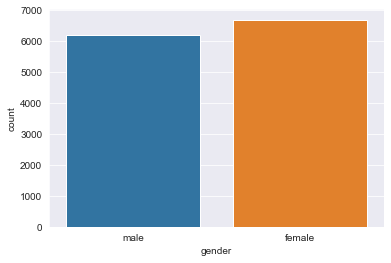

In [19]:
# Finding how many male and female members are present
sns.set_style('darkgrid')
sns.countplot(x='gender',data=df)

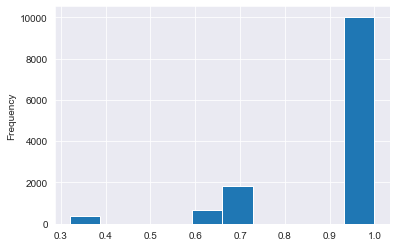

In [20]:
df['gender:confidence'].plot.hist()

In [21]:
df_female=combi[df['gender']=='female']
df_male=combi[df['gender']=='male']

In [22]:
# Finding the text only by females
text_extra_female=[text.split() for text in df_female['tidy_tweet']]
text_extra_female

[['watch', 'neighbour', 'catch', 'with', 'neighb'],
 ['seen', 'peopl', 'train', 'with', 'lamp', 'chair'],
 ['defin', 'fangirl', 'fanboy', 'shipper'],
 ['just',
  'love',
  'tree',
  'thi',
  'year',
  'never',
  'seen',
  'gorgeou',
  'thi',
  '#autumn',
  '#colour'],
 ['just', 'line', 'thi', 'repay'],
 ['will', 'even', 'need', 'sound', 'effect', 'divin', 'tonight'],
 ['glow', 'satisfact', 'glow'],
 ['lmao', 'dude', 'hella', 'scare', 'next', 'episod', 'end', 'yesterday'],
 ['thank', 'retweet'],
 ['girl', 'went', 'sleep', 'guy', 'just', 'floor', 'watch'],
 ['right', 'side'],
 ['except', 'onc', 'hallmark', 'movi', 'start', 'anyth', 'done'],
 ['leav', 'group', 'chat', 'more', 'than', 'min', 'miss', 'made', 'shit'],
 ['week',
  'brandon',
  'birthday',
  'there',
  'such',
  'thing',
  'birthday',
  'week',
  'weirdo',
  'novemb',
  'birthday',
  'month',
  'down'],
 ['thi', 'daughter', 'they', 'under'],
 ['went', 'wrong', 'nando', 'found', 'eventu', 'chilliesequalsfreenando'],
 ['those',


In [23]:
# Finding the text only by males
text_extra_male=[text.split() for text in df_male['tidy_tweet']]
text_extra_male

[['robbi',
  'respond',
  'critic',
  'after',
  'against',
  'eddi',
  'edward',
  '#worldtitleseri'],
 ['felt',
  'like',
  'they',
  'were',
  'friend',
  'live',
  'stori',
  'with',
  'them',
  '#retir',
  '#ian'],
 ['absolut',
  'ador',
  'when',
  'loui',
  'start',
  'song',
  'hit',
  'hard',
  'feel',
  'good'],
 ['look', 'typic', 'advanc', 'user'],
 ['gala',
  'bingo',
  'club',
  'bought',
  'largest',
  'high',
  'street',
  'bingo',
  'oper',
  'gala',
  'be',
  'taken',
  'over'],
 ['ditto',
  'still',
  'learn',
  'favourit',
  'retweet',
  'stuff',
  'least',
  'suck',
  'less',
  'than',
  'facebook',
  'haha'],
 ['understand', 'server'],
 ['yall',
  'lmfaoo',
  'right',
  'when',
  'choru',
  'came',
  'tear',
  'roll',
  'down',
  'face'],
 ['jame',
  'bond',
  'premier',
  'night',
  'oxt',
  'with',
  'hope',
  'live',
  'expect',
  '#spectr'],
 ['oppos',
  'pump',
  'where',
  'like',
  'hope',
  'like',
  'do',
  'jump',
  'where',
  'spread',
  'your',
  'feet'

## What are the most common words used by Males and Females?

In [24]:
words_male = list(itertools.chain(*text_extra_male))

# Creating counter
counts_male = collections.Counter(words_male)

counts_male.most_common(25)

[('that', 760),
 ('with', 534),
 ('have', 534),
 ('thi', 473),
 ('just', 465),
 ('your', 429),
 ('like', 391),
 ('they', 351),
 ('what', 303),
 ('when', 283),
 ('time', 258),
 ('from', 258),
 ('will', 257),
 ('love', 252),
 ('about', 251),
 ('make', 242),
 ('know', 202),
 ('look', 200),
 ('peopl', 197),
 ('there', 192),
 ('good', 189),
 ('think', 185),
 ('want', 179),
 ('need', 171),
 ('follow', 170)]

In [25]:
words_female = list(itertools.chain(*text_extra_female))

# Creating counter
counts_female = collections.Counter(words_female)

counts_female.most_common(25)


[('that', 802),
 ('with', 657),
 ('just', 612),
 ('have', 577),
 ('thi', 552),
 ('your', 530),
 ('like', 484),
 ('what', 397),
 ('love', 394),
 ('when', 364),
 ('make', 338),
 ('they', 318),
 ('about', 297),
 ('time', 290),
 ('want', 256),
 ('peopl', 249),
 ('from', 247),
 ('know', 233),
 ('follow', 218),
 ('look', 217),
 ('there', 205),
 ('will', 203),
 ('best', 192),
 ('thank', 189),
 ('here', 185)]

## Which gender makes more typos in their tweets?

In [26]:
# Creating a dictionary of words 

# if word in text exists in dictionary then gender spelled it correctly otherwise made a typo

dictionary={}

with open('words.txt') as f:
    for line in f:
        for word in line.split():
            dictionary[word]=1

In [27]:
# count to Count the no. of words females spelled incorrectly
count=0

# count_word to Count total words in dataframe of females
count_word=0
for text in text_extra_female:
    for word in text:
        count_word+=1
        if word not in dictionary:
            count+=1

print('No. of typos in females: ', count)
print('Total words: ',count_word)
print('error rate: ', count/count_word)

No. of typos in females:  21777
Total words:  53025
error rate:  0.41069306930693067


In [28]:
# count_m to Count the no. of words males spelled incorrectly
count_m=0

# count_word_m to Count total words in dataframe of males
count_word_m=0
for text in text_extra_male:
    for word in text:
        count_word_m+=1
        if word not in dictionary:
            count_m+=1

print('No. of typos in males: ', count_m)
print('Total words: ',count_word_m)
print('Error rate: ', count_m/count_word_m)

No. of typos in males:  21413
Total words:  51081
Error rate:  0.41919696168829895


## Feature Selection

In [29]:
# Selection of features
df['text'] = combi['tidy_tweet']

encoder = LabelEncoder()
df['fav_number'] = encoder.fit_transform(df['fav_number'])
df['link_color'] = encoder.fit_transform(df['link_color'])


## Classification 

### Naive Bayes 

In [30]:
Features = ['text','fav_number','link_color']
data_confident = df[df['gender:confidence']==1]
data_confident['all'] = data_confident['text']
accuracy1={}
# Running a for loop to check with multiple features
for i in range(1,len(Features)+1):
    # Filtering the features
    data_confident['all'] = data_confident.filter(Features[:i], axis=1)
    vectorizer = CountVectorizer()
    # Vectorizing the independent variable
    x = vectorizer.fit_transform(data_confident['all'])  # Independent variable
    encoder = LabelEncoder()
    # Encoding the dependent variable
    y = encoder.fit_transform(data_confident['gender'])  # Dependent variable
    #splitting the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    # Applying multinomial Naive Bayes
    nb = MultinomialNB()
    nb.fit(x_train, y_train)
    if i == 3:
        accuracy1[', '.join(Features[:i])] = nb.score(x_test, y_test)*100
for item in accuracy1.items():
    # Printing the accuracy of prediction made
    print (item[0],"   ",item[1])
    

text, fav_number, link_color     61.17764471057884


### k-Nearest Neighbors

In [31]:
data_NN = df

In [32]:

data_confident_NN = data_NN[data_NN['gender:confidence']==1]
Features_NN = ['text','fav_number','link_color']
k_value=[3,5,10]

In [33]:
accuracy_NN3={}
accuracy_NN5={}
accuracy_NN10={}

accuracy_NN=[accuracy_NN3,accuracy_NN5,accuracy_NN10]

# Running a for loop to check with multiple features
for k, acc in zip(k_value,accuracy_NN):
    for i in range(1,len(Features_NN)+1):
        # Filtering the features
        data_confident_NN['all'] = data_confident_NN.filter(Features_NN[:i], axis=1)
        vectorizer = CountVectorizer()
        # Vectorizing the independent variable
        x = vectorizer.fit_transform(data_confident_NN['all'])   # Independent variable
        encoder = LabelEncoder()
        # Encoding the dependent variable
        y = encoder.fit_transform(data_confident['gender'])  # Dependent variable
        #splitting the data into train and test
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        # Applying k-Nearest Neighbors
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(x_train, y_train)
        if i ==3:
            acc[', '.join(Features_NN[:i])] = neigh.score(x_test, y_test)*100
    print("--------------------------------k =",k,"------------------------------------------")
    for item in acc.items():
        # Printing the accuracy of prediction made
        print (item[0],"   ",item[1])


--------------------------------k = 3 ------------------------------------------
text, fav_number, link_color     53.243512974051896
--------------------------------k = 5 ------------------------------------------
text, fav_number, link_color     53.89221556886228
--------------------------------k = 10 ------------------------------------------
text, fav_number, link_color     52.99401197604791


Since k = 5 gives us the maximum accuracy we shall use that for ensembling.

In [34]:
best_k = 5
KNN = KNeighborsClassifier(n_neighbors=best_k)
KNN.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### Support Vector Machine

In [35]:
from sklearn.svm import SVC

In [36]:
model=SVC()

In [37]:
# Fitting the model
model.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
predictions = model.predict(x_test)

In [39]:
# Printing the confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test, predictions))
print('accuracy :', accuracy_score(y_test, predictions))

[[818 265]
 [516 405]]


              precision    recall  f1-score   support

           0       0.61      0.76      0.68      1083
           1       0.60      0.44      0.51       921

    accuracy                           0.61      2004
   macro avg       0.61      0.60      0.59      2004
weighted avg       0.61      0.61      0.60      2004

accuracy : 0.6102794411177644


## Ensemble modeling

In [40]:
# Ensembling using VotingClassifier
vote = VotingClassifier(estimators=[('MultinomialNB', nb), ('KNeighbors', KNN) , ('SVM',model)], voting='hard')
# Fitting the data
vote.fit(x_train, y_train)
print(classification_report(y_train, vote.predict(x_train), target_names=encoder.classes_))
# Final accuracy of predictions
accuracy_score(y_train, vote.predict(x_train))

              precision    recall  f1-score   support

      female       0.85      0.97      0.90      4284
        male       0.96      0.80      0.87      3732

    accuracy                           0.89      8016
   macro avg       0.90      0.88      0.89      8016
weighted avg       0.90      0.89      0.89      8016



0.8902195608782435